In [3]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
# sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


In [4]:
vcf = lcwgsus.read_vcf("results/imputation/wip_vcfs/oneKG/quilt.all.vcf.gz")
vcf

,chr,pos,ID,ref,alt,QUAL,FILTER,INFO,FORMAT,GM8,...,GM804,GM805,GM856,GM861,GM866,GM872,GM1110,GM1114,GM1117,GM1175
0,1,784860,.,T,C,.,PASS,EAF=0.93698;INFO_SCORE=0.96689;HWE=0.226;ERC=1...,GT:GP:DS,"1|1:0,0.027,0.973:1.973",...,"1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","0|1:0.001,0.998,0.001:1","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998"
1,1,785910,.,G,C,.,PASS,EAF=0.0198;INFO_SCORE=0.88125;HWE=1;ERC=2.0431...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
2,1,788538,.,G,A,.,PASS,EAF=0.1077;INFO_SCORE=0.97114;HWE=0.0409;ERC=2...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","1|0:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|1:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
3,1,818725,.,C,T,.,PASS,EAF=0.01737;INFO_SCORE=0.86779;HWE=1;ERC=6.030...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
4,1,819249,.,A,G,.,PASS,EAF=0.01777;INFO_SCORE=0.87254;HWE=1;ERC=5.031...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749996,9,138155904,.,T,G,.,PASS,EAF=0.81564;INFO_SCORE=0.77496;HWE=1;ERC=223.9...,GT:GP:DS,"1|1:0,0.092,0.908:1.908",...,"1|1:0,0.002,0.998:1.998","0|1:0.001,0.526,0.474:1.473","1|1:0,0.002,0.998:1.998","1|1:0,0.393,0.607:1.606","1|1:0,0.003,0.997:1.997","0|1:0.001,0.998,0.001:1","0|1:0.021,0.978,0.001:0.98","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.149,0.851:1.851"
749997,9,138156356,.,C,T,.,PASS,EAF=0.00364;INFO_SCORE=1;HWE=1;ERC=2.05388;EAC...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|1:0.006,0.993,0.001:0.995","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.997,0.003,0:0.003","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
749998,9,138159068,.,G,A,.,PASS,EAF=0.0704;INFO_SCORE=0.83474;HWE=1;ERC=10.031...,GT:GP:DS,"0|0:0.857,0.143,0:0.143",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|1:0,0.002,0.998:1.998","1|0:0.17,0.828,0.002:0.832","0|0:0.898,0.102,0:0.102","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","0|0:0.729,0.271,0:0.272"
749999,9,138172038,.,C,T,.,PASS,EAF=0.1538;INFO_SCORE=0.7347;HWE=0.789;ERC=33....,GT:GP:DS,"0|0:0.957,0.043,0:0.043",...,"0|0:0.998,0.002,0:0.002","1|0:0.57,0.429,0:0.43","0|0:0.998,0.002,0:0.002","0|1:0.854,0.146,0:0.146","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","1|0:0.151,0.848,0.001:0.851","0|0:0.998,0.002,0:0.002","0|0:0.955,0.045,0:0.045","0|0:0.998,0.002,0:0.002"


In [6]:
vcf = lcwgsus.extract_info(vcf, attribute = 'INFO')
vcf

,chr,pos,ID,ref,alt,QUAL,FILTER,FORMAT,GM8,GM42,...,GM856,GM861,GM866,GM872,GM1110,GM1114,GM1117,GM1175,EAF,INFO_SCORE
0,1,784860,.,T,C,.,PASS,GT:GP:DS,"1|1:0,0.027,0.973:1.973","1|1:0,0.002,0.998:1.998",...,"1|1:0,0.002,0.998:1.998","0|1:0.001,0.998,0.001:1","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998",0.93698,0.96689
1,1,785910,.,G,C,.,PASS,GT:GP:DS,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",0.01980,0.88125
2,1,788538,.,G,A,.,PASS,GT:GP:DS,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","1|0:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|1:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",0.10770,0.97114
3,1,818725,.,C,T,.,PASS,GT:GP:DS,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",0.01737,0.86779
4,1,819249,.,A,G,.,PASS,GT:GP:DS,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",0.01777,0.87254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749996,9,138155904,.,T,G,.,PASS,GT:GP:DS,"1|1:0,0.092,0.908:1.908","1|1:0,0.002,0.998:1.998",...,"1|1:0,0.002,0.998:1.998","1|1:0,0.393,0.607:1.606","1|1:0,0.003,0.997:1.997","0|1:0.001,0.998,0.001:1","0|1:0.021,0.978,0.001:0.98","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.149,0.851:1.851",0.81564,0.77496
749997,9,138156356,.,C,T,.,PASS,GT:GP:DS,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.997,0.003,0:0.003","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002",0.00364,1.00000
749998,9,138159068,.,G,A,.,PASS,GT:GP:DS,"0|0:0.857,0.143,0:0.143","0|0:0.998,0.002,0:0.002",...,"1|1:0,0.002,0.998:1.998","1|0:0.17,0.828,0.002:0.832","0|0:0.898,0.102,0:0.102","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","0|0:0.729,0.271,0:0.272",0.07040,0.83474
749999,9,138172038,.,C,T,.,PASS,GT:GP:DS,"0|0:0.957,0.043,0:0.043","0|0:0.943,0.057,0:0.057",...,"0|0:0.998,0.002,0:0.002","0|1:0.854,0.146,0:0.146","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","1|0:0.151,0.848,0.001:0.851","0|0:0.998,0.002,0:0.002","0|0:0.955,0.045,0:0.045","0|0:0.998,0.002,0:0.002",0.15380,0.73470


26973


Text(0.5, 1.0, 'INFO > 0.8')

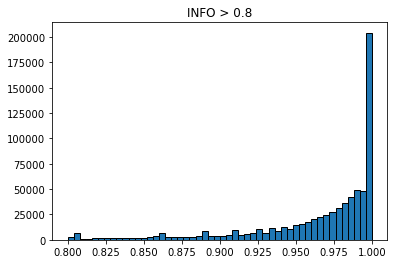

In [19]:
f = vcf[vcf['INFO_SCORE'] > 0.8]
print(750001-f.shape[0])
plt.hist(f['INFO_SCORE'], bins = 50, ec = 'black')
plt.title('INFO > 0.8')

98163


(array([2.03600e+03, 2.19000e+03, 2.18500e+03, 2.61700e+03, 2.75100e+03,
        6.80200e+03, 2.33200e+03, 2.46300e+03, 2.81100e+03, 2.91200e+03,
        2.98400e+03, 3.44600e+03, 7.17500e+03, 3.18400e+03, 3.54300e+03,
        3.59800e+03, 4.31900e+03, 7.59200e+03, 3.99700e+03, 4.24900e+03,
        5.47100e+03, 7.61500e+03, 4.96200e+03, 5.95700e+03, 8.25600e+03,
        5.96700e+03, 9.20200e+03, 6.48600e+03, 9.66600e+03, 7.53200e+03,
        1.02500e+04, 1.06630e+04, 1.09910e+04, 1.13220e+04, 1.16350e+04,
        1.23810e+04, 1.29920e+04, 1.49170e+04, 1.54550e+04, 1.60520e+04,
        1.76840e+04, 1.89660e+04, 2.03790e+04, 2.20940e+04, 2.39390e+04,
        2.55500e+04, 2.59610e+04, 2.19420e+04, 2.60000e+01, 2.04339e+05]),
 array([0.90001  , 0.9020098, 0.9040096, 0.9060094, 0.9080092, 0.910009 ,
        0.9120088, 0.9140086, 0.9160084, 0.9180082, 0.920008 , 0.9220078,
        0.9240076, 0.9260074, 0.9280072, 0.930007 , 0.9320068, 0.9340066,
        0.9360064, 0.9380062, 0.940006 , 0.942

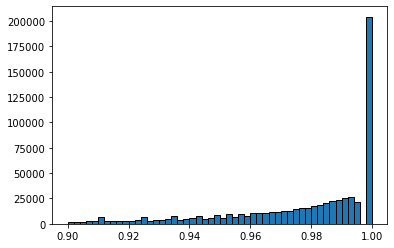

In [14]:
f = vcf[vcf['INFO_SCORE'] > 0.9]
print(750001-f.shape[0])
plt.hist(f['INFO_SCORE'], bins = 50, ec = 'black')
plt.title('INFO > 0.9')

Text(0.5, 1.0, '0.85 < INFO < 0.95')

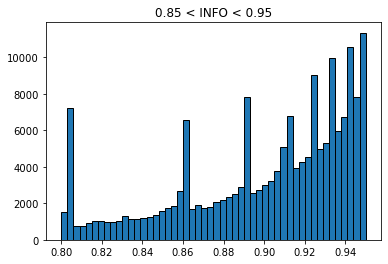

In [20]:
tmp = vcf[(vcf['INFO_SCORE'] > 0.8) & (vcf['INFO_SCORE'] < 0.95)]
plt.hist(tmp['INFO_SCORE'], bins = 50, ec = 'black')
plt.title('0.85 < INFO < 0.95')